## Building the dataset

In [1]:
from PIL import Image
import numpy as np
import glob

def build_dataset():
	org_dataset = []
    
	for i in range(1, 16):
		filelist = glob.glob('./yalefaces/yalefaces/subject'+str(i).zfill(2)+"*")
		for fname in filelist:
			img = np.array(Image.open(fname))
			img = img.reshape(img.shape[0]*img.shape[1])
			org_dataset.append(img)

	org_dataset = np.array(org_dataset)
    
	return org_dataset

org_dataset = build_dataset()
num_components = len(org_dataset)

## Normalizing dataset by subtracting the mean vector

In [2]:
def normalize(org_dataset):
	mean_vector = np.mean(org_dataset, axis=0)
	dataset = org_dataset - mean_vector

	return dataset, mean_vector

dataset, mean_vector = normalize(org_dataset)

## Calculating eigen vectors and eigen values

In [3]:
from numpy import linalg as la

def calc_eig_val_vec(dataset):
	cov_mat = np.dot(dataset, dataset.T)
	eig_values, eigen_vectors = la.eig(cov_mat)
	eig_vectors = np.dot(dataset.T, eigen_vectors)
	for i in range(eig_vectors.shape[1]):
		eig_vectors[:, i] = eig_vectors[:, i]/la.norm(eig_vectors[:, i])
	return eig_values.astype(float), eig_vectors.astype(float)

eig_values, eig_vectors = calc_eig_val_vec(dataset)

/home/pritish/.local/lib/python3.5/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


## Get 'k' eigen faces

In [4]:
def pca(eig_values, eig_vectors, k):
	k_eig_val = eig_values.argsort()[-k:][::-1]
	eigen_faces = []
    
	for i in k_eig_val:
		eigen_faces.append(eig_vectors[:, i])

	eigen_faces = np.array(eigen_faces)
    
	return eigen_faces

eigen_faces = pca(eig_values, eig_vectors, num_components)

## Reconstruct images

In [5]:
def reconstruct_images(eigen_faces, mean_vector):
	org_dim_eig_faces = []
    
	for i in range(eigen_faces.shape[0]):
		org_dim_eig_faces.append(eigen_faces[i].reshape(243, 320))

	org_dim_eig_faces = np.array(org_dim_eig_faces)
    
	return org_dim_eig_faces

org_dim_eig_faces = reconstruct_images(eigen_faces, mean_vector)

## Plotting the first k=10 eigen values

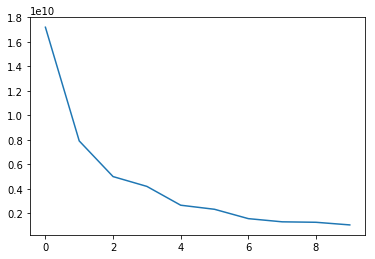

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(eig_values[:10])
plt.show()
plt.clf()

## Calculating number of components required to capture 50% energy

In [7]:
from numpy import trapz

total_energy = trapz(eig_values, dx=1)
print("Total Energy:", total_energy)

k = 0
while True:
	k_energy = trapz(eig_values[:k], dx=1)
	print("Energy captured by", k, "components:", k_energy)
	if k_energy >= 0.5*total_energy:
		break
	k += 1

print("Number of components to capture 50% energy:", k)

Total Energy: 47692294393.4
Energy captured by 0 components: 0.0
Energy captured by 1 components: 0.0
Energy captured by 2 components: 12546502748.6
Energy captured by 3 components: 18994191128.3
Energy captured by 4 components: 23585255322.4
Energy captured by 5 components: 27007219964.5
Number of components to capture 50% energy: 5


## Plotting top 10 eigen faces

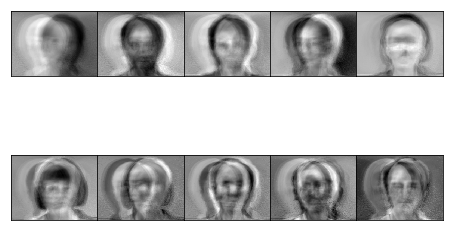

In [8]:
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(2, 5, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)   

i = 0
for g in gs:
    ax = plt.subplot(g)
    ax.imshow(org_dim_eig_faces[i], cmap = plt.get_cmap("gray"))
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1

plt.show()
plt.clf()

## Reconstructing two random images

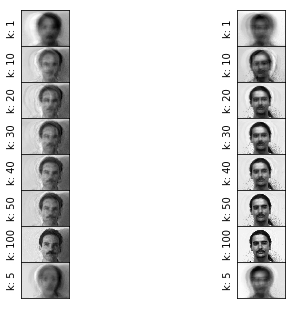

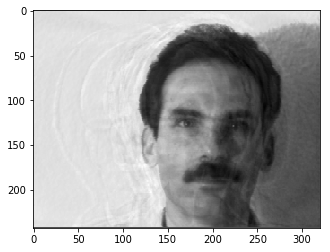

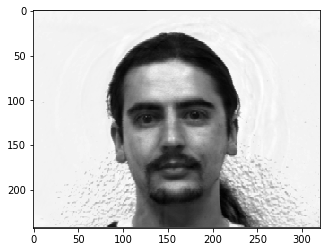

In [9]:
import random

k = np.concatenate(([1, 10, 20, 30, 40, 50, 100], [k]))

r1 = 0
r2 = 0
while r1==r2:
    r1 = random.randint(0, len(dataset)-1)
    r2 = random.randint(0, len(dataset)-1)

sample1 = dataset[r1]
sample2 = dataset[r2]

def project(org_dim_input, eigen_faces):
    return np.dot(org_dim_input, eigen_faces.T)

def reconstruct(projected_input, eigen_faces):
    reconstructed_input = []
    reconstructed_input = np.dot(projected_input, eigen_faces)
    mean_vector = np.mean(org_dataset, axis=0)
    return reconstructed_input + mean_vector

outputs = []
for j in k:
    projected_input1 = project(sample1, eigen_faces[:j])
    reconstructed_input1 = reconstruct(projected_input1, eigen_faces[:j])
    outputs.append(reconstructed_input1)

    projected_input2 = project(sample2, eigen_faces[:j])
    reconstructed_input2 = reconstruct(projected_input2, eigen_faces[:j])
    outputs.append(reconstructed_input2)

gs = gridspec.GridSpec(len(k), 2, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)   

i = 0
for g in gs:
    ax = plt.subplot(g)
    plt.ylabel("k: "+str(k[int(i/2)]))
    ax.imshow(outputs[i].reshape(243, 320), cmap = plt.get_cmap("gray"))
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1    

plt.show()
plt.clf()

plt.imshow(outputs[12].reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.show()
plt.clf()

plt.imshow(outputs[13].reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.show()
plt.clf()

# Face recognition using k-nearest neighnor

## Splittting training and testing data

In [10]:
train = []
test = []

i = 0
while i!=15:
    r1 = random.randint(0,10)
    r2 = random.randint(0,10)
    if r1!=r2:
        for j in range(11):
            if j==r1 or j==r2:
                test.append(np.concatenate((org_dataset[i*11+j],[i])))
            else:
                train.append(np.concatenate((org_dataset[i*11+j],[i])))
        i += 1

np.random.shuffle(train)
np.random.shuffle(test)
        
train = np.array(train)
test = np.array(test)

trainX = train[:, :train.shape[1]-1]
testX = test[:, :test.shape[1]-1]
trainY = train[:, train.shape[1]-1]
testY = test[:, test.shape[1]-1]

## Defining knn methods

In [11]:
from __future__ import division
import sklearn
from sklearn import preprocessing
from scipy.spatial import distance
import matplotlib.pyplot as plt

def knn(temp_test, temp_train, best_k, temp_train_Y):
    dist = np.ndarray(shape=(len(temp_test), len(temp_train)))
    for i in range (0, len(temp_test)):
        for j in range (0, len(temp_train)):
            dist[i][j] = distance.euclidean(temp_test[i], temp_train[j])
    k_best = np.ndarray(shape=(len(temp_test), best_k))
    for i in range (0, len(temp_test)):
        k_best[i] = dist[i].argsort()[:best_k][::1]
    y_pred = np.ndarray(shape=(len(temp_test)))
    for i in range (0, len(temp_test)):
        count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        for j in range (0, best_k):
            pred_k = temp_train_Y[int(k_best[i][j])]
            count[pred_k] += 1
        y_pred[i] = np.argmax(count)
    return y_pred

def knn_cross_val(trainX, trainY):
    k = [3, 5, 7, 9, 11]
    knn_num_folds = 5
    knn_cv_acc = np.ndarray(shape=(knn_num_folds, len(k)))
    n = int(round((len(trainX))/len(k)))

    for i in range (knn_num_folds):
        if i==(len(k)-1):
            temp_test = trainX[n*i:]
            temp_test_Y = trainY[n*i:]
            temp_train = trainX[:n*i]
            temp_train_Y = trainY[:n*i]
        elif i==0:
            temp_test = trainX[:n]
            temp_test_Y = trainY[:n]
            temp_train = trainX[n:]
            temp_train_Y = trainY[n:]
        else:
            temp = np.split(trainX, [n*i, n*(i+1)])
            temp_Y = np.split(trainY, [n*i, n*(i+1)])
            temp_test = temp[1]
            temp_train = np.concatenate((temp[0], temp[2]))
            temp_test_Y = temp_Y[1]
            temp_train_Y = np.concatenate((temp_Y[0], temp_Y[2]))
        
        for l in range(len(k)):
            y = knn(temp_test, temp_train, k[l], temp_train_Y)

            c = 0
            for j in range(0, len(temp_test_Y)):
                if temp_test_Y[j]==y[j]:
                    c += 1
            knn_cv_acc[i, l] = c/len(temp_test_Y)

    accuracies = np.mean(knn_cv_acc, axis=0)
    best_k_knn = k[np.argmax(accuracies)]

    return best_k_knn

## Cross-validation for finding best k for pca for face recognition

In [12]:
def cross_val(trainX, trainY):
    num_folds = 5
    k = [10, 20, 30, 40, 50]
    cv_acc = np.ndarray((num_folds, len(k)))
    n = int(round((len(trainX))/num_folds))
    
    for i in range(num_folds):
        if i==(num_folds-1):
            temp_test = trainX[n*i:]
            temp_test_Y = trainY[n*i:]
            temp_train = trainX[:n*i]
            temp_train_Y = trainY[:n*i]
        elif i==0:
            temp_test = trainX[:n]
            temp_test_Y = trainY[:n]
            temp_train = trainX[n:]
            temp_train_Y = trainY[n:]
        else:
            temp = np.split(trainX, [n*i, n*(i+1)])
            temp_Y = np.split(trainY, [n*i, n*(i+1)])
            temp_test = temp[1]
            temp_train = np.concatenate((temp[0], temp[2]))
            temp_test_Y = temp_Y[1]
            temp_train_Y = np.concatenate((temp_Y[0], temp_Y[2]))   
            
        for j in range(len(k)):
            t_train = project(temp_train, eigen_faces[:k[j]])
            t_test = project(temp_test, eigen_faces[:k[j]])
        
            t_train = sklearn.preprocessing.normalize(t_train)
            t_test = sklearn.preprocessing.normalize(t_test)
        
            best_k = knn_cross_val(t_train, temp_train_Y)
            
            pred_y = knn(t_test, t_train, best_k, temp_train_Y)
            
            c = 0
            for m in range(0, len(temp_test_Y)):
                if temp_test_Y[m]==pred_y[m]:
                    c += 1

            cv_acc[i, j] = c/len(temp_test_Y)
    
    accuracies = np.mean(cv_acc, axis=0)
    best_k_pca = k[np.argmax(accuracies)]
    
    return best_k_pca

best_k_pca = cross_val(trainX, trainY)
print("Best k for PCA:", best_k_pca)

projected_trainX = project(trainX, eigen_faces[:best_k_pca])
projected_testX = project(testX, eigen_faces[:best_k_pca])

trainX_norm = sklearn.preprocessing.normalize(projected_trainX)
testX_norm = sklearn.preprocessing.normalize(projected_testX)

best_k = knn_cross_val(trainX_norm, trainY)
pred_y = knn(testX_norm, trainX_norm, best_k, trainY)

c = 0
for j in range(0, len(testY)):
	if testY[j]==pred_y[j]:
		c += 1

accuracy = c/len(testY)
print("Test accuracy:", accuracy)

Best k for PCA: 40
Test accuracy: 0.8666666666666667


## Testing random image from the dataset

Test image:


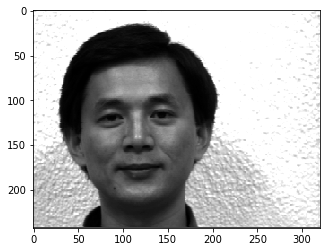

Face recognized is of subject06


In [13]:
r = random.randint(0, len(testX)-1)

print("Test image:")
plt.imshow(testX[r].reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.show()
plt.clf()

print("Face recognized is of subject"+str(int(pred_y[r]+1)).zfill(2))